In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
from osgeo import ogr
import gdal
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

# hand made functions
from Rouss1 import Imreduction, gp2idomain, gp2cellids,cellidBD, get_heads, get_spdis, get_MNTbbox

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "workingDis"
model_name="dis_test"
exe_name="../../exe/mf6"

In [3]:
R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
MNT_path= "../../../../../MNT_demo_5m.tif"
Agly_path="../data/Fleuves/Fleuve_Agly.shp" # path to Agly

# get x0,y0,y1 and x1
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

In [4]:
#spatial parameters
Lx = x1-x0
Ly = y1-y0
nlay = 1
ncol = 50
nrow = 50
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 10. # if no mnt is provided
idomain = np.zeros((nrow*ncol))

In [5]:
# import a mnt and extract topography data --> add it to top of the cells

from PIL import Image
im = Image.open(MNT_path) # add path to MNT.tif
imar = np.array(im) # create an array
imar[imar==0]=None # None where it's nodata

top = Imreduction(imar,nrow,ncol)

In [6]:
R = gp.read_file(R_path) # import shapefile with geopandas
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

#cells inside the aquifer become active and return the lst of the cellids
lst_domain = gp2idomain(R,grid,idomain,area=3)

In [7]:
### BC sea

# import the shapefile that correspond to the BC
BCsea_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids(grid,BC_sea,idomain,type="line")
# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [75]:
#BC Agly
BC_Agly = gp.read_file(Agly_path)
BC_Agly = BC_Agly.sort_values(by="ORDRE").set_index("ORDRE") # sort multilines by the ORDRE column 
                                                             #that I have added to the shp


ID_BDCARTO                                               406328
ETAT                                                  Permanent
LARGEUR                                        De 0 à 15 mètres
NATURE                                      Cours d'eau naturel
NAVIGABLE                                         Non navigable
POS_SOL                                                       0
TOPONYME                                          fleuve l'agly
SENS                                            Sens du tronçon
CLASSE                                                      100
geometry      (LINESTRING (660407 6188264, 660457 6188244), ...
Name: 15, dtype: object

In [89]:
#extract cellids from the river
ix = GridIntersect(grid)
lst_Agy = [];o = 0

for i in range(BC_Agly.shape[0]):
    cellids = ix.intersect_linestring(BC_Agly.iloc[i].geometry).cellids
    for k in range(cellids.size):
        if cellids[k] not in lst_Agy:
            lst_Agy.append(cellids[k])
lst_Agy

[(15, 0),
 (15, 1),
 (16, 0),
 (16, 1),
 (17, 0),
 (18, 0),
 (18, 1),
 (19, 1),
 (19, 2),
 (19, 3),
 (19, 4),
 (20, 4),
 (20, 5),
 (20, 6),
 (20, 7),
 (19, 6),
 (19, 7),
 (18, 7),
 (18, 8),
 (18, 9),
 (18, 10),
 (17, 12),
 (18, 11),
 (18, 12),
 (17, 13),
 (17, 14),
 (17, 15),
 (16, 15),
 (16, 16),
 (17, 16),
 (17, 17),
 (16, 17),
 (16, 18),
 (16, 19),
 (16, 20),
 (17, 20),
 (17, 21),
 (17, 22),
 (16, 23),
 (17, 23),
 (16, 24),
 (17, 24),
 (15, 25),
 (16, 25),
 (17, 25),
 (15, 26),
 (16, 26),
 (16, 27),
 (16, 28),
 (16, 29),
 (16, 30),
 (17, 30),
 (17, 31),
 (17, 32),
 (17, 33),
 (17, 34),
 (17, 35),
 (17, 36),
 (18, 36),
 (18, 37),
 (18, 38),
 (19, 38),
 (19, 39),
 (19, 40),
 (18, 41),
 (19, 41),
 (18, 42),
 (18, 43),
 (18, 44),
 (17, 44),
 (17, 45),
 (17, 46),
 (16, 47),
 (17, 47)]

In [8]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
kh = 1e-4*np.ones(nrow*ncol)
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=kh, save_flows=True,save_specific_discharge=True)

#recharge
mm = 100
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = mm/1000/365/86400)

# output control
headfile = '{}.hds'.format(model_name)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])

# constant heads package
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', maxbound=len(chd_lst), 
                                               stress_period_data=chd_lst, save_flows=True)


Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

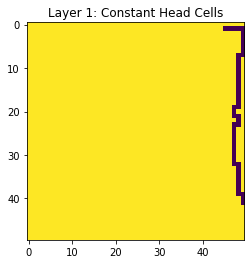

In [9]:
# vizualize the BC cells
iper = 0
ra = chd.stress_period_data.get_data(key=iper)

ibd = np.ones((nlay, nrow, ncol), dtype=np.int)
for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [11]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model dis_test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package chd...


In [12]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [13]:
# retrieve heads and spdis 
head=get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

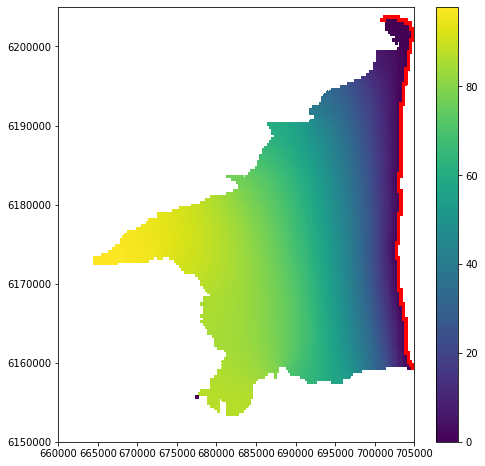

In [14]:
# make a plot

fig = plt.figure(figsize=(8,8))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
#ml.plot_specific_discharge(spdis[0],color="w",width=0.005)
ml.plot_bc("chd",color="r")
plt.colorbar(hmesh)

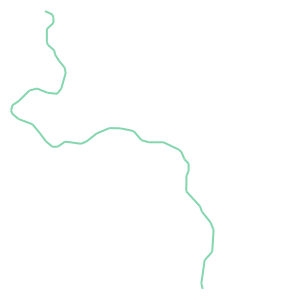

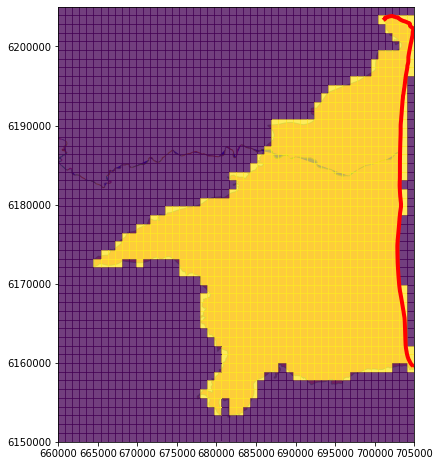

In [106]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(aspect='equal')

mm = fp.plot.PlotMapView(model=gwf)
#mm.plot_grid()
fp.plot.plot_shapefile(R_path,ax=ax,facecolor="Red",alpha=0.5)
fp.plot.plot_shapefile(Agly_path,ax=ax,facecolor="blue")
mm.plot_array(dis.idomain.array,alpha=0.5)
fp.plot.plot_shapefile(BCsea_path,ax=ax,edgecolor="r",facecolor="none",linewidth=4)